<a href="https://colab.research.google.com/github/d-atallah/implicit_gender_bias/blob/main/word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [1]:
# !pip install gensim

In [2]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [3]:
import itertools
import json
import os

from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from joblib import Parallel, delayed
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import scipy.stats as stats
import spacy

# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")

In [4]:
pd.options.mode.chained_assignment = None

# Load Files

These files contain a sample of **social media posts** from the paper *RtGender: A Corpus for Studying Differential Responses to Gender* by Rob Voigt, David Jurgens, Vinodkumar Prabhakaran, Dan Jurafsky and Yulia Tsvetkov. Documentation is available [here](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fnlp.stanford.edu%2Frobvoigt%2Frtgender%2F). The sample includes an equal number of posts from the five data sources balanced on the gender of the original poster. Replacement was used to ensure less robust sources are adequately represented.

In [5]:
filepath_data = 'assets/data/sample'
filepath_models = 'assets/models'

In [6]:
filepath_train = os.path.join(filepath_data, 'train_one_million.csv')
filepath_validate = os.path.join(filepath_data, 'validate_one_million.csv')
filepath_test = os.path.join(filepath_data, 'test_one_million.csv')

This file contains the **stop words** available in the Natural Language Toolkit. Gendered pronouns have been removed.

In [7]:
filepath_stopwords = os.path.join(filepath_data, 'stopwords.txt')

In [8]:
with open(filepath_stopwords, 'r') as file:
    stopwords = json.load(file)['stop_words']

This file contains **nouns** from the HolisticBias dataset, a project of the Responsible Natural Language Processing team at Facebook Research. The dataset is described in the paper *I'm sorry to hear that: Finding New Biases in Language Models with a Holistic Descriptor Dataset* by Eric Michael Smith, Melissa Hall, Melanie Kambadur, Eleonora Presani, and Adina Williams. Documentation is available [here](https://github.com/facebookresearch/ResponsibleNLP/tree/main/holistic_bias/dataset/v1.1).

In [9]:
filepath_nouns = os.path.join(filepath_data, 'gendered_nouns.txt')

In [10]:
with open (filepath_nouns, 'r') as file:
    nouns = json.load(file)

nouns_male = ' '.join([item for sublist in nouns['male'] for item in sublist])
nouns_female = ' '.join([item for sublist in nouns['female'] for item in sublist])

This file contains **pronouns** from Grammarly as described in the article *A Guide to Personal Pronouns and How They've Evolved*. The article includes additional neopronouns, pronouns that “refer to people entirely without reference to gender” (Grammarly, 2021). Documentation is available [here](https://www.grammarly.com/blog/gender-pronouns/).

In [11]:
filepath_pronouns = os.path.join(filepath_data, 'gendered_pronouns.txt')

In [12]:
with open(filepath_pronouns, 'r') as file:
    pronouns = json.load(file)

pronouns_male = ' '.join(pronouns['male'])
pronouns_female = ' '.join(pronouns['female'])

# Define Functions

## Load Files

In [13]:
def create_dataframe(filepath):
    """
    Read a CSV file into a DataFrame, remove leading spaces from column names, drop rows with missing values,
    and remove the column named "stratify" if it exists.
    
    Parameters:
    - filepath: str, path to the CSV file to be read.
    
    Returns:
    - dataframe: DataFrame, processed DataFrame with leading spaces removed from column names, NaN values dropped,
      and the "stratify" column removed if it exists.
    """
    # Read the CSV file into a DataFrame
    dataframe = pd.read_csv(filepath)
    
    # Remove leading spaces from column names
    dataframe.columns = [col.strip() for col in dataframe.columns]
    
    # Remove the "stratify" column if it exists
    if 'stratify' in dataframe.columns:
        dataframe = dataframe.drop(columns=['stratify'])
    
    # Drop rows with missing values
    dataframe = dataframe.dropna()
    
    return dataframe


## Tokenize Text

In developing a language model for English Tweets, Nguyen et al. (2020) used *TweetTokenizer* from the NLTK toolkit. *TweetTokenizer* preserves emojis and hashtags and attempts to normalize words with extra letters. Documentation is available [here](https://www.nltk.org/api/nltk.tokenize.casual.html).

In [14]:
class LemmaTokenizer:
    """
    A tokenizer class that optionally applies NLTK's WordNetLemmatizer to both tokens and stop words,
    and removes stop words based on a custom JSON file. The class can be configured to perform
    lemmatization, stop word removal, both, or neither, ensuring consistency between token and stop word
    processing. Based on code developed by Daniel Atallah.
    """

    def __init__(self, lemmatize=False, remove_stopwords=False, stopwords_file=None):
        """
        Initializes the LemmaTokenizer instance with options for lemmatization and stop word removal,
        and loads (and optionally lemmatizes) stop words from a specified JSON file if stop word removal
        is enabled.
        """
        self.lemmatize = lemmatize
        self.remove_stopwords = remove_stopwords and stopwords_file is not None
        self.lemmatizer = WordNetLemmatizer() if lemmatize else None
        self.tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
        self.stop_words = self._load_stopwords(stopwords_file) if self.remove_stopwords else set()

    def _load_stopwords(self, stopwords_file):
        """
        Loads and optionally lemmatizes stop words from a JSON file.
        """
        with open(stopwords_file, 'r') as file:
            stopwords = set(json.load(file))
        if self.lemmatize:
            return {self.lemmatizer.lemmatize(word) for word in stopwords}
        return stopwords

    def __call__(self, text):
        """
        Tokenizes and optionally lemmatizes and removes stop words from the input text.
        """
        tokens = self.tokenizer.tokenize(text)
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        if self.remove_stopwords:
            tokens = [token for token in tokens if token.lower() not in self.stop_words]
            
        return tokens
        

In [15]:
def add_tokens(dataframe, column_text, tokenizer):
    """
    Tokenize text data in a DataFrame column in parallel and add the tokens as a new column.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the text data.
    - column_text (str): The name of the column containing text to be tokenized.
    - tokenizer (function): A function that takes a string and returns a list of tokens.

    Returns:
    - pd.DataFrame: The original DataFrame with an additional 'tokens' column containing the tokenized text.
    """
    # Tokenize text for each row in parallel
    tokens = Parallel(n_jobs=-1)(
        delayed(tokenizer)(text) for text in dataframe[column_text]
    )
    
    # Assign the tokenized text to a new column in the DataFrame
    dataframe['tokens'] = tokens
    
    return dataframe
    

In [16]:
def save_tokens(dataframe, column_text, filename, filepath, filepath_stopwords):
    """
    Save tokenized versions of text from a DataFrame column to CSV files.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing text data.
    - column_text (str): Column name of the text to tokenize.
    - filename (str): Base filename for the output CSV files.
    - file_path (str): Directory path for the output CSV files.
    - stopwords (list of str): List of stopwords to use in tokenization.
    """
    lemmatize_options = [True, False]
    remove_stopwords_options = [True, False]

    for lemmatize in lemmatize_options:
        for remove_stopwords in remove_stopwords_options:
            tokenizer = LemmaTokenizer(lemmatize, remove_stopwords, filepath_stopwords)
            dataframe_tokenized = add_tokens(dataframe, column_text, tokenizer)
            dataframe_name = f"{filename}_lemmatization_{lemmatize}_stopwords_{remove_stopwords}.csv"
            dataframe_tokenized.to_csv(os.path.join(filepath, dataframe_name), index=False)
            

## Train Embeddings

In [17]:
def train_model(dataframe, column_text, lemmatize, remove_stopwords, filepath_stopwords, **kwargs):
    """
    Trains a Word2Vec model on the tokenized text from a specified column in a DataFrame.

    Parameters:
    - dataframe: The DataFrame containing the text data.
    - column_text: The name of the column containing text to tokenize.
    - lemmatize: Whether to use lemmatization in tokenization.
    - remove_stopwords: Whether to remove stopwords in tokenization.
    - filepath_stopwords: A list of stopwords to remove if remove_stopwords is True.

    Returns:
    - A trained Word2Vec model.
    """
    tokenizer = LemmaTokenizer(lemmatize, remove_stopwords, filepath_stopwords)
    dataframe = add_tokens(dataframe, column_text, tokenizer)
    model = Word2Vec(dataframe['tokens'], **kwargs)
    
    return model
    

In [18]:
def save_models(dataframe, column_text, filename, filepath, filepath_stopwords, **kwargs):
    """
    Trains Word2Vec models with different configurations based on lemmatization and stopwords removal options,
    and saves each model's word vectors to a specified directory.

    Parameters:
    - dataframe (DataFrame): The DataFrame containing the text data.
    - column_text (str): The name of the DataFrame column containing text to be processed.
    - filepath (str): The directory path where the trained model word vectors will be saved.
    - filepath_stopwords (str): The filepath to the stopwords list to be used for text processing.
    """
    
    # Options for processing the text
    lemmatize_options = [True, False]
    remove_stopwords_options = [True, False]

    # Iterate over all combinations of processing options
    for lemmatize in tqdm(lemmatize_options):
        for remove_stopwords in tqdm(remove_stopwords_options):
            # Train the model with the current combination of options
            model = train_model(dataframe, column_text, lemmatize, remove_stopwords, filepath_stopwords, **kwargs)
            
            # Create a filename for the model based on its configuration
            model_name = f"{filename}_lemmatization_{lemmatize}_stopwords_{remove_stopwords}.wordvectors"
            
            # Save the model's word vectors to the specified filepath
            model.wv.save(os.path.join(filepath, model_name))
            

In [19]:
def tune_parameters(dataframe, column_text, lemmatize, remove_stopwords, filename, filepath, filepath_stopwords):
    """
    Tunes parameters for training a Word2Vec model and saves each model's word vectors.
    
    Parameters:
    - dataframe: DataFrame containing the text data.
    - column_text: String, name of the column containing text to tokenize.
    - lemmatize: Boolean, whether to use lemmatization in tokenization.
    - remove_stopwords: Boolean, whether to remove stopwords in tokenization.
    - filepath: String, directory path to save the model word vectors.
    - filepath_stopwords: String, path to the stopwords file.
    """
    
    # Define the range of parameters for the Word2Vec model
    parameters = {
        'vector_size': [100, 150],
        'alpha': [0.025, 0.05],
        'window': [10, 15],
        'sample': [0],
        'sg': [0, 1],  # Skip-gram: 0 for CBOW, 1 for skip-gram
        'hs': [0, 1],  # Hierarchical softmax: 0 for negative sampling, 1 for hs
        'workers': [15],  # Number of worker threads
        'epochs': [10],  # Number of training epochs
        'seed': [42]
    }

    # Generate all combinations of parameters
    combinations = list(itertools.product(*parameters.values()))

    # Iterate through each combination of parameters
    for combination in tqdm(combinations):
        # Convert the current combination of parameters into a dictionary
        kwargs = dict(zip(parameters.keys(), combination))

        # Train the model with the current combination of options
        model = train_model(dataframe, column_text, lemmatize, remove_stopwords, filepath_stopwords, **kwargs)

        # Create a filename for the model based on its configuration
        model_name = f"{filename}_{combination}.wordvectors"
        
        # Save the model's word vectors to the specified filepath
        model.wv.save(os.path.join(filepath, model_name))


## Compare Embeddings

In [20]:
def calculate_similarities(filepath_wordvectors, file, nouns_male, nouns_female, pronouns_male, pronouns_female, filepath_stopwords):
    """
    Calculate similarities between tokens derived from male and female nouns and pronouns, 
    and compute silhouette scores for male and female groups.

    Parameters:
    - filepath_wordvectors: str, path to the directory containing word vector models.
    - file: str, filename of the KeyedVectors model to be loaded.
    - nouns_male, nouns_female, pronouns_male, pronouns_female: Lists of male and female nouns and pronouns.
    - filepath_stopwords: str, path to the stopwords file.

    Returns:
    - tuple:
        - tokens (list of str): Combined list of male and female tokens.
        - matrix (numpy.ndarray): A matrix of cosine similarities between the tokens, rounded to three decimals.
        - silhouette_male (float): Silhouette score for male tokens.
        - silhouette_female (float): Silhouette score for female tokens.
    """
    # Load the KeyedVectors model
    filepath_model = os.path.join(filepath_wordvectors, file)
    model = KeyedVectors.load(filepath_model)

    # Extract base filename without extension for use in naming output files
    filename = file.split('.')[0]

    # Determine lemmatization and stopwords removal settings from the filename
    lemmatize = filename.split('_')[2] == 'True'
    remove_stopwords = filename.split('_')[4] == 'True'

    # Initialize the tokenizer with the determined settings
    tokenizer = LemmaTokenizer(lemmatize, remove_stopwords, filepath_stopwords)

    # Tokenize the provided nouns and pronouns
    tokens_male = [token for token in tokenizer(nouns_male)[::2] + tokenizer(pronouns_male) if token in model.key_to_index]
    tokens_female = [token for token in tokenizer(nouns_female)[::2] + tokenizer(pronouns_female) if token in model.key_to_index]
    tokens = tokens_male + tokens_female

    # Create an empty matrix to store similarities
    matrix = np.zeros((len(tokens), len(tokens)))

    # Retrieve vectors for each token and calculate cosine similarities
    vectors = [model.get_vector(token) for token in tokens]

    for i, vector in enumerate(vectors):
        matrix[i] = model.cosine_similarities(vector, vectors)

    # Calculate average similarities within and between gender groups
    average_male_male = np.mean(matrix[:len(tokens_male), :len(tokens_male)])
    average_female_female = np.mean(matrix[len(tokens_male):, len(tokens_male):])
    average_male_female = np.mean(matrix[:len(tokens_male), len(tokens_male):])

    # Compute silhouette scores for male and female groups
    silhouette_male = ((1 - average_male_female) - (1 - average_male_male)) / max((1 - average_male_female), (1 - average_male_male))
    silhouette_female = ((1 - average_male_female) - (1 - average_female_female)) / max((1 - average_male_female), (1 - average_female_female))
    
    # Return the token list, similarity matrix rounded to three decimals, and silhouette scores
    return tokens, matrix.round(3), silhouette_male, silhouette_female


In [21]:
def compare_embeddings(filepath_wordvectors, nouns_male, nouns_female, pronouns_male, pronouns_female, filepath_stopwords):
    """
    Compare embeddings by calculating silhouette scores for male and female tokens
    across multiple word vector models and return the results in a dataframe.

    Parameters:
    - filepath_wordvectors (str): The directory path where word vector models are stored.
    - nouns_male, nouns_female, pronouns_male, pronouns_female (list of str): Lists of male and female nouns and pronouns.
    - filepath_stopwords (str): The path to the stopwords file.

    Returns:
    - pandas.DataFrame: A dataframe with rows representing word vector model filenames
      and two columns for silhouette scores of male and female tokens, respectively.
    """
    # Retrieve a list of filenames for models ending with '.wordvectors'
    wordvectors = [file for file in os.listdir(filepath_wordvectors) if file.endswith('.wordvectors')]

    # Initialize an empty matrix to hold silhouette scores for each model
    matrix = np.zeros((len(wordvectors), 2))

    # Loop through each word vector model and calculate silhouette scores
    for i, file in enumerate(wordvectors):
        # Calculate silhouette scores for the current model
        _, _, silhouette_male, silhouette_female = calculate_similarities(
            filepath_wordvectors, file, nouns_male, nouns_female, pronouns_male, pronouns_female, filepath_stopwords)
        
        # Store the silhouette scores in the matrix
        matrix[i] = (silhouette_male.round(3), silhouette_female.round(3))

    # Create a DataFrame with the matrix data, wordvectors as the index, and column names 'male' and 'female'
    dataframe = pd.DataFrame(matrix, index=wordvectors, columns=['male', 'female'])
    dataframe['average'] = (dataframe['male'] + dataframe['female']) / 2

    return dataframe
    

## Calculate Bias

Garg et al. (2018) use a different approach to assess the similarity between a set of neutral words and two groups, first subtracting the distance between each group and a neutral word, then summing the results across words. This approach gives equal weight to each word, unlike the approach below. Documentation is available [here](https://pubmed.ncbi.nlm.nih.gov/29615513/).

In [22]:
def calculate_bias(tokens, vector_male, vector_female, model):
    """
    Calculate the bias score for a single row based on tokens.

    Parameters:
    - tokens (list of str): List of tokens for a single text entry.
    - vector_male (np.array): Embedding vector representing male attributes.
    - vector_female (np.array): Embedding vector representing female attributes.
    - model: Model with a `get_mean_vector` method to compute embeddings.

    Returns:
    - float: The bias score for the given list of tokens.
    """
    embedding = model.get_mean_vector(tokens)
    bias_male = np.linalg.norm(vector_male - embedding)
    bias_female = np.linalg.norm(vector_female - embedding)
    
    return bias_male, bias_female


This function uses Euclidean distance instead of cosine similarity. The advantage of using cosine similarity is that the distance between vectors is normalized. However, because the number of male and female nouns in the HolisticBias dataset is similar, it is not necessary to use a normalized measure, particularly if computational efficiency is compromised. Garg et al. (2018) also use Euclidean distance.

In [23]:
def unpack_bias(row, vector_male, vector_female, model):
    """
    Calls a function to calculate bias values for a given row.
    
    Parameters:
    - row: The current row of the DataFrame being processed.
    - vector_male: The vector representation for "male" to be used in bias calculation.
    - vector_female: The vector representation for "female" to be used in bias calculation.
    - model: The model used for calculating bias.
    
    Returns:
    - tuple: A tuple containing the calculated male_bias and female_bias.
    """
    return calculate_bias(row, vector_male, vector_female, model)

In [24]:
def add_bias(dataframe, column_tokens, tokens_male, tokens_female, model):
    """
    Calculates bias scores for each row in the DataFrame based on male and female tokens
    and adds two new columns ('male_bias', 'female_bias') to the DataFrame with these scores.
    
    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the text data.
    - column_tokens (str): The column name containing lists of tokens from which biases are calculated.
    - tokens_male (list of str): List of tokens associated with male attributes used to compute the male bias vector.
    - tokens_female (list of str): List of tokens associated with female attributes used to compute the female bias vector.
    - model: A model object that provides a `get_mean_vector` method to compute mean word embeddings for the given tokens.
    
    Returns:
    - pd.DataFrame: The original DataFrame with two additional columns ('male_bias' and 'female_bias') containing the calculated bias scores.
    """
    # Compute mean vectors for male and female tokens
    vector_male = model.get_mean_vector(tokens_male)
    vector_female = model.get_mean_vector(tokens_female)
    
    # Apply unpack_bias to each row to calculate male and female biases, storing results in a new series
    bias = dataframe[column_tokens].apply(
        lambda row: unpack_bias(row, vector_male, vector_female, model)
    )
    
    # Split the resulting series of tuples into two lists and assign them as new columns in the dataframe
    dataframe['bias_male'], dataframe['bias_female'] = zip(*bias)
    
    return dataframe


In [25]:
def save_bias(filepath_wordvectors, filepath_input, filepath_output, column_tokens,
              nouns_male, nouns_female, pronouns_male, pronouns_female, filepath_stopwords):
    """
    Processes and saves bias metrics for male and female nouns and pronouns across multiple models.
    
    Parameters:
    - filepath_wordvectors: Directory containing model files with the '.wordvectors' extension.
    - filepath_input: Directory containing input CSV files.
    - filepath_output: Directory where output CSV files will be saved.
    - column_tokens: Column name in the DataFrame for the tokens.
    - nouns_male, nouns_female, pronouns_male, pronouns_female: Lists of male and female nouns and pronouns.
    - filepath_stopwords: Path to the stopwords file.
    """
    
    # Get list of model files ending with '.wordvectors'
    wordvectors = [file for file in os.listdir(filepath_wordvectors) if file.endswith('.wordvectors')]

    for file in tqdm(wordvectors):
        # Load the KeyedVectors model
        filepath_model = os.path.join(filepath_wordvectors, file)
        model = KeyedVectors.load(filepath_model)  
        
        # Extract base filename without extension for use in naming output files
        filename = file.split('.')[0]
        
        # Construct the filename for the input CSV based on the model's name
        filename_input = f"{filename}.csv"
        # Load the corresponding CSV file as a DataFrame
        dataframe = pd.read_csv(os.path.join(filepath_input, filename_input))
        
        # Determine lemmatization and stopwords removal settings from the filename
        lemmatize = filename.split('_')[2] == 'True'
        remove_stopwords = filename.split('_')[4] == 'True'
        
        # Initialize the tokenizer with the determined settings
        tokenizer = LemmaTokenizer(lemmatize, remove_stopwords, filepath_stopwords)
        # Tokenize the provided nouns and pronouns
        tokens_nouns_male = tokenizer(nouns_male)
        tokens_nouns_female = tokenizer(nouns_female)
        tokens_pronouns_male = tokenizer(pronouns_male)
        tokens_pronouns_female = tokenizer(pronouns_female)

        # Calculate and save bias metrics for nouns
        dataframe_nouns = add_bias(dataframe, column_tokens, tokens_nouns_male, tokens_nouns_female, model)
        dataframe_nouns_name = f"{filename}_nouns.csv"
        dataframe_nouns.to_csv(os.path.join(filepath_output, dataframe_nouns_name), index=False)
        
        # Calculate and save bias metrics for pronouns
        dataframe_pronouns = add_bias(dataframe, column_tokens, tokens_pronouns_male, tokens_pronouns_female, model)
        dataframe_pronouns_name = f"{filename}_pronouns.csv"
        dataframe_pronouns.to_csv(os.path.join(filepath_output, dataframe_pronouns_name), index=False)


In [26]:
def calculate_token_bias(nouns_male, nouns_female, pronouns_male, pronouns_female, filepath_model):
    """
    Calculate gender bias in word vectors.
    
    Parameters:
    - nouns_male: list of male-associated nouns
    - nouns_female: list of female-associated nouns
    - pronouns_male: list of male pronouns
    - pronouns_female: list of female pronouns
    - filepath_model: path to the pre-trained word vectors model
    
    Returns:
    - DataFrame containing the similarities and bias calculations.
    """
    # Load model
    model = KeyedVectors.load(filepath_model)

    # Retrieve vectors
    keys = model.index_to_key
    vectors = [model.get_vector(key) for key in keys]

    # Tokenize male and female nouns and pronouns
    tokenizer = LemmaTokenizer(lemmatize=True)
    tokens_male = tokenizer(nouns_male)[::2] + tokenizer(pronouns_male)
    tokens_female = tokenizer(nouns_female)[::2] + tokenizer(pronouns_female)

    # Create male and female vector representations
    vector_male = model.get_mean_vector(tokens_male)
    vector_female = model.get_mean_vector(tokens_female)

    # Calculate biases
    bias_male = model.cosine_similarities(vector_male, vectors)
    bias_female = model.cosine_similarities(vector_female, vectors)

    # Create a similarity DataFrame
    dataframe = pd.DataFrame([bias_male, bias_female], index=['bias_male', 'bias_female'], columns=keys).T

    # Add a bias column and sort values
    dataframe['bias'] = dataframe['bias_male'] - dataframe['bias_female']
    dataframe = dataframe.sort_values('bias')
    dataframe = dataframe[~dataframe.index.isin(tokens_male + tokens_female)]
    
    return add_pos(dataframe)


In [27]:
def add_pos(dataframe):
    """
    Adds a column 'pos' to the dataframe, containing the part of speech
    for each index assuming the index is composed of strings, using SpaCy.
    
    Parameters:
    - dataframe: The DataFrame to which the POS tags will be added.
    
    Returns:
    - The original DataFrame with an added 'pos' column.
    """
    # Load the SpaCy model
    nlp = spacy.load("en_core_web_sm")
    
    # Ensure the index is converted to a list of strings for SpaCy processing
    index_as_list = dataframe.index.astype(str).tolist()
    
    # Process each index string with SpaCy, then extract the pos_ attribute of the first token
    # Correcting the function call here: nlp(token)[0].pos_
    pos_tags = [nlp(token)[0].pos_ for token in index_as_list]
    
    # Assign the POS tags to a new column in the DataFrame
    dataframe['pos'] = pos_tags
    
    return dataframe


## Evaluate Data

In [28]:
def filter_dataframe(dataframe, column_tokens, token):
    """
    Filters the DataFrame to include only the rows where the specified token
    is present in the list of tokens within the specified column.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to filter.
    - column_tokens (str): The name of the column containing lists of tokens.
    - token (str): The specific token to filter for.

    Returns:
    - pd.DataFrame: A filtered DataFrame including only rows where `token`
                    is found within the list of tokens in `column_tokens`.
    """
    return dataframe[dataframe[column_tokens].apply(lambda tokens: token in tokens)]


In [29]:
def count_sources(dataframe, dataframe_tokens, column_source='source', column_tokens='tokens', n=10):
    """
    Generates a DataFrame of token counts by source for the top 10 tokens
    sorted by bias, adds a sum column, and sorts by this sum.

    Parameters:
    - dataframe (pd.DataFrame): The main DataFrame to filter.
    - dataframe_tokens (pd.DataFrame): DataFrame with tokens and their bias.
    - column_tokens (str): The name of the column containing lists of tokens.

    Returns:
    - pd.DataFrame: DataFrame of token counts by source, including a sum column,
                    sorted by the sum column in descending order.
    """
    # Take the absolute value of the bias column
    dataframe_tokens = dataframe_tokens.drop('pos', axis=1).abs()
    
    dictionary = {}
    
    # Get top n tokens sorted by bias
    for token in dataframe_tokens.sort_values('bias').index[:n]:
        # Count occurrences by source
        count = filter_dataframe(dataframe, column_tokens, "'" + token + "'").groupby(column_source)[column_tokens].count()
        dictionary[token] = count

    # Convert the dictionary to DataFrame and transpose
    dataframe_counts = pd.DataFrame(dictionary).T
    
    # Add a sum column
    dataframe_counts['Total'] = dataframe_counts.sum(axis=1)
    
    # Sort by the sum column in descending order
    dataframe_counts = dataframe_counts.sort_values('Total', ascending=False)
    
    return dataframe_counts


In [30]:
def find_analogy(token, vector_input, vector_output, model):
    """
    Finds the most analogous word to the input word, ensuring the same part of speech,
    based on gender vectors and a word embedding model.
    
    Parameters:
    - token: The word to find an analogy for.
    - vector_a, vector_b: Vectors defining the analogy direction.
    - model: The word embedding model (e.g., from Gensim).
    
    Returns:
    - A tuple of the analogous word and its part of speech, or None if no match is found.
    """
    # Process the input token to get its part of speech
    pos = nlp(token)[0].pos_
    
    # Find the most similar words based on the analogy
    analogies = model.most_similar(positive=[vector_output, token], negative=[vector_input], topn=20)
    
    # Filter for words with the same POS as the input word
    analogies_filtered = [x for x, _ in analogies if nlp(x)[0].pos_ == pos]
    
    # Return the first match, or None if there's no match
    return analogies_filtered[0] if analogies_filtered else None


## Visualize Data

In [31]:
def create_heatmap(tokens, matrix):
    """
    Create and display a heatmap from a given matrix and corresponding labels, and return the figure and axes objects for further customization.

    Parameters:
    - tokens (list of str): A list of strings representing the labels for the matrix's rows and columns.
    - matrix (numpy.ndarray): A 2D array of shape (n, n) containing the similarity scores or any numerical values to be plotted in the heatmap.

    Returns:
    - fig (matplotlib.figure.Figure): The Figure object containing the heatmap.
    - ax (matplotlib.axes.Axes): The Axes object containing the heatmap.
    """
    # Initialize the plot with a specific figure size
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Display the matrix as a heatmap
    im = ax.imshow(matrix)

    # Set the tick labels and locations for both axes
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_xticklabels(labels=tokens)
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_yticklabels(labels=tokens)

    # Rotate the x-axis tick labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add text annotations within each cell of the heatmap
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            ax.text(j, i, f"{matrix[i, j]:.1f}", ha="center", va="center", color="w")   

    return fig, ax


In [32]:
def plot_hist(dataframe, column_gender='op_gender', column_bias='bias'):

    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

    ax.hist(dataframe[dataframe[column_gender] == 'M'][column_bias], bins=50, density=True, alpha=0.5, label='Original Poster Male')
    ax.hist(dataframe[dataframe[column_gender] == 'W'][column_bias], bins=50, density=True, alpha=0.5, label='Original Poster Female')

    ax.set_title('Response Bias')
    ax.set_xlabel('Calculated Bias')
    ax.set_ylabel('Density')
    ax.legend()

    return fig, ax
    

In [33]:
def get_bootstrap(dataframe, column_male, column_female, ax):
    """
    Adds a bootstrap regression line to the plot on the provided axes.
    
    Parameters:
    - dataframe: The pandas DataFrame containing the data.
    - column_male: The name of the column containing male data.
    - column_female: The name of the column containing female data.
    - ax: The Matplotlib axes object where the line will be plotted.
    """
    dataframe_resampled = dataframe.sample(frac=0.5, replace=True)
    
    x = dataframe_resampled[column_male]
    y = dataframe_resampled[column_female]
    
    m, b = np.polyfit(x, y, 1)
    
    y_fit = m * x + b
    
    ax.plot(x, y_fit, color='C0', alpha=0.2)
    

In [34]:
styles = [{
    'selector': 'th, td',
    'props': [
        ('max-width', '400px'),  # Set max width
        ('word-wrap', 'break-word'),  # Ensure text wraps within the max width
        ('text-align', 'left'),  # Align text to the left
        ('white-space', 'normal')  # Allow normal text wrapping
    ]
}]


# Call Functions

## Load Files

In [35]:
dataframe_train = create_dataframe('assets/data/sample/train_lemmatization_True_stopwords_False_five_million.csv')

In [36]:
dataframe_train.head()

,source,source_id,op_gender,response_text
0,TED,TED5828,W,Beautiful... If only more people could see thi...
1,RED,RED906982,M,Idk man. Cubs striking has looked NASTY lately...
2,FBW,FBW3327456,W,Having a hard time right now!! Im right there😥
3,FIT,FIT189959,W,Welcome! Fitocracy is a great place to track y...
4,RED,RED650418,W,Ich hab Sims4 deinstalliert nachdem ich eine H...


## Tokenize Text

In [37]:
# save_tokens(dataframe_train, 'response_text', 'train', '../Data/Tokenize Text', filepath_stopwords)

## Train Embeddings

In [38]:
# save_models(dataframe_train, 'response_text', 'ALL', 'assets/models/tune/source', filepath_stopwords, **parameters)

In [39]:
# sources = ['FBC', 'FBW', 'FIT', 'RED', 'TED']

# for source in sources:
#     # Filter the dataframe for the current source
#     dataframe_filtered = dataframe_train[dataframe_train['source'] == source]
    
#     # Save the models for the filtered dataframe
#     save_models(dataframe_filtered, 'response_text', f'{source}', 'assets/models/tune/source/', filepath_stopwords , **parameters)


## Tune Embeddings

### Source

The embeddings trained on all five sources have better silhouette scores than the embeddings trained on specific sources. Among those trained on all five sources, the version with lemmatization without stopwords performs best (train_lemmatization_True_stopwords_False.wordvectors). This model serves as the basis for further development.

In [40]:
# Compare models trained on all five sources of data
compare_embeddings('assets/models/tune/source', nouns_male, nouns_female, pronouns_male, pronouns_female, filepath_stopwords).sort_index()

,male,female,average
ALL_lemmatization_False_stopwords_False.wordvectors,0.127,0.194,0.1605
ALL_lemmatization_False_stopwords_True.wordvectors,0.116,0.187,0.1515
ALL_lemmatization_True_stopwords_False.wordvectors,0.112,0.194,0.1530
ALL_lemmatization_True_stopwords_True.wordvectors,0.097,0.196,0.1465
FBC_lemmatization_False_stopwords_False.wordvectors,0.157,0.160,0.1585
FBC_lemmatization_False_stopwords_True.wordvectors,0.149,0.174,0.1615
FBC_lemmatization_True_stopwords_False.wordvectors,0.153,0.209,0.1810
FBC_lemmatization_True_stopwords_True.wordvectors,0.148,0.191,0.1695
FBW_lemmatization_False_stopwords_False.wordvectors,0.085,0.225,0.1550
FBW_lemmatization_False_stopwords_True.wordvectors,0.087,0.215,0.1510


### Parameters

In [41]:
# tune_parameters(dataframe_train, 'response_text', True, False, 'train_lemmatization_True_stopwords_False', 'assets/models/tune', filepath_stopwords)

In [42]:
compare_embeddings('assets/models/tune/v6', nouns_male, nouns_female, pronouns_male, pronouns_female, filepath_stopwords).sort_values('average', ascending=False)

,male,female,average
"train_lemmatization_True_stopwords_False_(100, 0.025, 15, 0, 1, 1, 15, 10, 42).wordvectors",0.152,0.132,0.1420
"train_lemmatization_True_stopwords_False_(100, 0.025, 15, 0, 1, 0, 15, 10, 42).wordvectors",0.121,0.160,0.1405
"train_lemmatization_True_stopwords_False_(100, 0.05, 15, 0, 1, 1, 15, 10, 42).wordvectors",0.128,0.143,0.1355
"train_lemmatization_True_stopwords_False_(100, 0.05, 15, 0, 1, 0, 15, 10, 42).wordvectors",0.136,0.125,0.1305
"train_lemmatization_True_stopwords_False_(150, 0.05, 15, 0, 1, 0, 15, 10, 42).wordvectors",0.136,0.124,0.1300
"train_lemmatization_True_stopwords_False_(100, 0.025, 15, 0, 0, 0, 15, 10, 42).wordvectors",0.105,0.150,0.1275
"train_lemmatization_True_stopwords_False_(100, 0.05, 10, 0, 1, 1, 15, 10, 42).wordvectors",0.134,0.121,0.1275
"train_lemmatization_True_stopwords_False_(100, 0.025, 10, 0, 1, 1, 15, 10, 42).wordvectors",0.114,0.140,0.1270
"train_lemmatization_True_stopwords_False_(150, 0.025, 15, 0, 0, 1, 15, 10, 42).wordvectors",0.094,0.158,0.1260
"train_lemmatization_True_stopwords_False_(100, 0.025, 15, 0, 0, 1, 15, 10, 42).wordvectors",0.094,0.157,0.1255


The following parameters return the second best silhouette score overall, with only marginally worse performance than the more computationally intensive approach using hierarchical softmax.

In [43]:
parameters = {
        'vector_size': 100,
        'alpha': 0.025,
        'window': 15,
        'sample': 0,
        'sg': 1,  # Skip-gram: 0 for CBOW, 1 for skip-gram
        'hs': 0,  # Hierarchical softmax: 0 for negative sampling, 1 for hs
        'workers': 15,  # Number of worker threads
        'epochs': 10,  # Number of training epochs
        'seed': 42
    }


### Records

In [44]:
# Combine the base filepath with the specific file name to get the full path
filepath_one_million = os.path.join(filepath_data, 'train_lemmatization_True_stopwords_False_one_million.csv')

# Create a DataFrame by reading data from the specified CSV file
dataframe_one_million = create_dataframe(filepath_one_million)

# Train a Word2Vec model on the text data contained in the 'response_text' column of the DataFrame
# model_one_million = train_model(dataframe_one_million, 'response_text', True, False, filepath_stopwords, **parameters)

# Save the model's word vectors to the specified filepath
# model_one_million.wv.save(os.path.join('assets/models/tune', 'train_lemmatization_True_stopwords_False_one_million.wordvectors'))

In [45]:
# Combine the base filepath with the specific file name to get the full path
filepath_three_million = os.path.join(filepath_data, 'train_lemmatization_True_stopwords_False_three_million.csv')

# Create a DataFrame by reading data from the specified CSV file
dataframe_three_million = create_dataframe(filepath_three_million)

# Train a Word2Vec model on the text data contained in the 'response_text' column of the DataFrame
# model_three_million = train_model(dataframe_three_million, 'response_text', True, False, filepath_stopwords, **parameters)

# Save the model's word vectors to the specified filepath
# model_three_million.wv.save(os.path.join('assets/models/tune', 'train_lemmatization_True_stopwords_False_three_million.wordvectors'))

In [46]:
# Combine the base filepath with the specific file name to get the full path
filepath_five_million = os.path.join(filepath_data, 'train_lemmatization_True_stopwords_False_five_million.csv')

# Create a DataFrame by reading data from the specified CSV file
dataframe_five_million = create_dataframe(filepath_five_million)

# Train a Word2Vec model on the text data contained in the 'response_text' column of the DataFrame
# model_five_million = train_model(dataframe_five_million, 'response_text', True, False, filepath_stopwords, **parameters)

# Save the model's word vectors to the specified filepath
# model_five_million.wv.save(os.path.join('assets/models/tune', 'train_lemmatization_True_stopwords_False_five_million.wordvectors'))

In [47]:
compare_embeddings('assets/models/tune', nouns_male, nouns_female, pronouns_male, pronouns_female, filepath_stopwords)

,male,female,average
train_lemmatization_True_stopwords_False_one_million.wordvectors,0.122,0.152,0.1370
train_lemmatization_True_stopwords_False_three_million.wordvectors,0.074,0.227,0.1505
train_lemmatization_True_stopwords_False_five_million.wordvectors,0.115,0.194,0.1545


## Calculate Bias

In [48]:
# save_bias('assets/models/tune', 'assets/data', 'assets/data/bias', 'tokens',
#           nouns_male, nouns_female, pronouns_male, pronouns_female, filepath_stopwords)

## Evaluate Data

In a perfect model, the upper left and lower right quadrants would have values nearing one, while the upper right and lower left quadrants would have values nearing zero. The values in the upper left and lower right quadrants are slightly higher than the upper right and lower left quadrants, particularly in the lower right quadrant. However, there are meaningful semantic and syntactic relationships in the upper right and lower left quadrants. For example, the semantically related words father, son, and husband are similar to the words mother, daughter, and wife. Furthermore, the syntactically related words he, him, and his are similar to she, her, and hers.

In [49]:
tokens, matrix, _, _ = calculate_similarities('assets/models/tune', 'train_lemmatization_True_stopwords_False_five_million.wordvectors', nouns_male, nouns_female, pronouns_male, pronouns_female, filepath_stopwords)

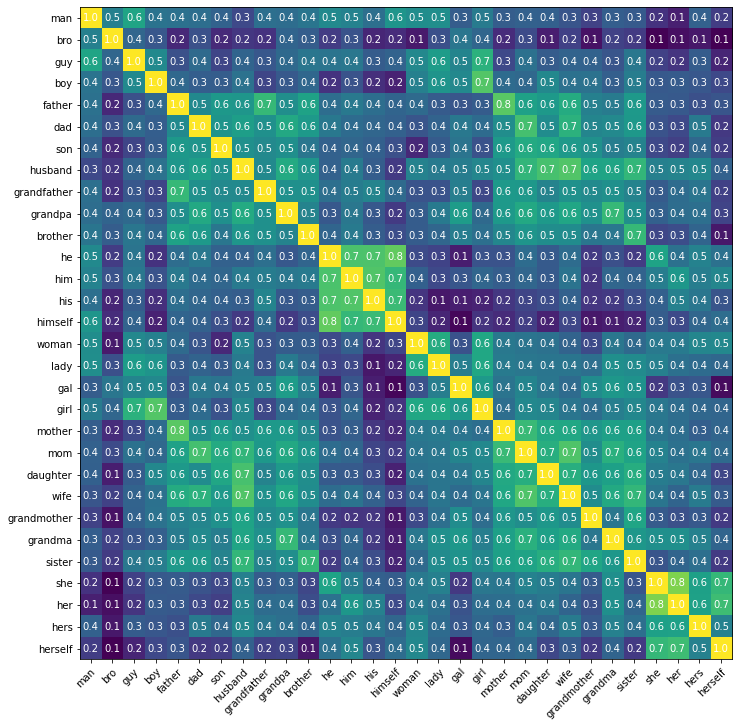

In [50]:
fig, ax = create_heatmap(tokens, matrix)
plt.savefig('assets/images/heatmap.png')
plt.show()

### Document Bias

Bias is similar whether the original poster is male or female at a document level, regardless of representation. 

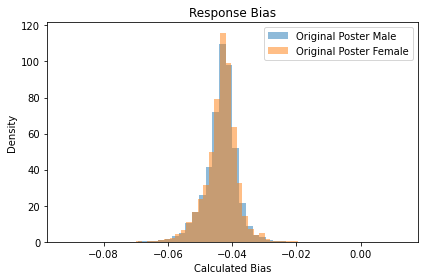

In [51]:
dataframe_nouns = create_dataframe('assets/data/bias/train_lemmatization_True_stopwords_False_five_million_nouns.csv')
dataframe_nouns['bias'] = dataframe_nouns['bias_male'] - dataframe_nouns['bias_female']
fix, ax = plot_hist(dataframe_nouns, column_gender='op_gender', column_bias='bias')
plt.savefig('assets/images/distribution_document_nouns.png')

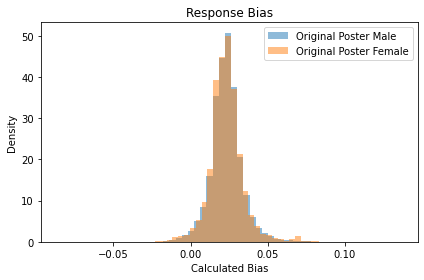

In [52]:
dataframe_pronouns = create_dataframe('assets/data/bias/train_lemmatization_True_stopwords_False_five_million_pronouns.csv')
dataframe_pronouns['bias'] = dataframe_pronouns['bias_male'] - dataframe_pronouns['bias_female']
fix, ax = plot_hist(dataframe_pronouns, column_gender='op_gender', column_bias='bias')

There is little variance in the bias calculation, suggesting that at a document level, it may not be sensitive enough to identify implicit bias.

In [53]:
# Calculate means and standard deviations
mean_bias_nouns = dataframe_nouns['bias'].mean()
std_bias_nouns = dataframe_nouns['bias'].std()
mean_bias_pronouns = dataframe_pronouns['bias'].mean()
std_bias_pronouns = dataframe_pronouns['bias'].std()

# Print calculations
print(f'Noun Representation: Mean = {round(mean_bias_nouns, 3)}, Standard Deviation = {round(std_bias_nouns, 3)}')
print(f'Noun Representation: Mean = {round(mean_bias_pronouns, 3)}, Standard Deviation = {round(std_bias_pronouns, 3)}')

Noun Representation: Mean = -0.043, Standard Deviation = 0.005
Noun Representation: Mean = 0.023, Standard Deviation = 0.011


### Source Bias

In [54]:
dataframe_nouns.groupby('source')['bias'].agg(['mean', 'std'])

,mean,std
source,,
FBC,-0.043484,0.004756
FBW,-0.043818,0.006320
FIT,-0.044143,0.004641
RED,-0.043177,0.004720
TED,-0.042351,0.004220


In [55]:
dataframe_pronouns.groupby('source')['bias'].agg(['mean', 'std'])

,mean,std
source,,
FBC,0.022758,0.009779
FBW,0.025195,0.013192
FIT,0.019833,0.009978
RED,0.023611,0.009642
TED,0.024991,0.008530


### Token Bias

There is more variance at the token level, suggesting it may be possible to identify implicit bias through the presence of specific tokens.

In [56]:
filepath_model = 'assets/models/tune/train_lemmatization_True_stopwords_False_five_million.wordvectors'

# Create a dataframe with male and female bias for each token
dataframe_bias_tokens = calculate_token_bias(nouns_male, nouns_female, pronouns_male, pronouns_female, filepath_model)

# Calculate mean and standard deviation
mean_bias = dataframe_bias_tokens['bias'].mean()
std_bias = dataframe_bias_tokens['bias'].std()

# Print calculations
print(f'Mean = {round(mean_bias, 3)}, Standard Deviation = {round(std_bias, 3)}')

Mean = 0.023, Standard Deviation = 0.061


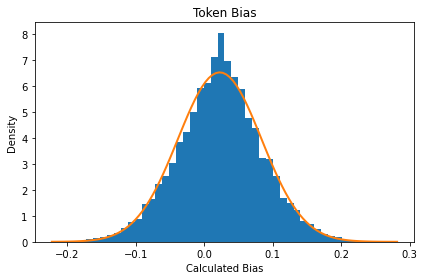

In [57]:
fig, axs = plt.subplots(figsize=(6, 4), tight_layout=True)

# Create a histogram
axs.hist(dataframe_bias_tokens['bias'], bins=50, density=True)

# Generate points on the x axis between the min and max of the data
x = np.linspace(min(dataframe_bias_tokens['bias']), max(dataframe_bias_tokens['bias']), 100)

# Calculate the PDF values for each x
y = stats.norm.pdf(x, mean_bias, std_bias)

axs.plot(x, y, linewidth=2)

axs.set_title('Token Bias')
axs.set_xlabel('Calculated Bias')
axs.set_ylabel('Density')

plt.savefig('assets/images/distribution_words.png')
plt.show()

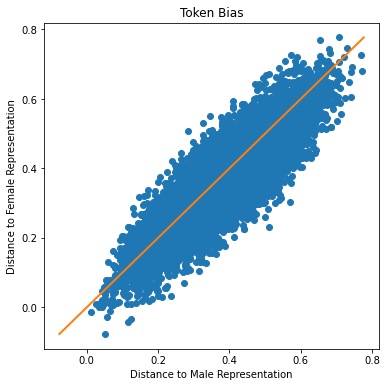

In [58]:
fig, axs = plt.subplots(figsize=(6, 6))

# Create a scatter plot comparing male and female similarities
axs.scatter(dataframe_bias_tokens['bias_male'], dataframe_bias_tokens['bias_female'])

# Adjust the range for x values
x_start = min(min(dataframe_bias_tokens['bias_male']), min(dataframe_bias_tokens['bias_female']))
x_stop = max(max(dataframe_bias_tokens['bias_male']), max(dataframe_bias_tokens['bias_female']))
x = np.linspace(start=x_start, stop=x_stop, num=10)

# Add the x=y line
axs.plot(x, x, label='x=y line', color='C01', linewidth=2)

axs.set_title('Token Bias')
axs.set_xlabel('Distance to Male Representation')
axs.set_ylabel('Distance to Female Representation')

plt.savefig('assets/images/scatter.png')
plt.show()

In [59]:
dataframe_count = dataframe_bias_tokens.groupby('pos')['bias'].agg(['count']).sort_values(['count'], ascending=False).head()
dataframe_count['share'] = dataframe_count['count'] / dataframe_count['count'].sum()
dataframe_count.round(3)

,count,share
pos,,
NOUN,4341,0.375
VERB,3519,0.304
PROPN,1768,0.153
ADJ,1346,0.116
ADV,617,0.053


#### Outliers

In [60]:
lower = mean_bias - 2 * std_bias
upper = mean_bias + 2 * std_bias

dataframe_tokens_male = dataframe_bias_tokens[dataframe_bias_tokens['bias'] > upper]
dataframe_tokens_female = dataframe_bias_tokens[dataframe_bias_tokens['bias'] < lower]

Nouns are among the most common tokens biased towards males, followed by verbs.

In [61]:
dataframe_count_male = dataframe_tokens_male.groupby('pos')['bias'].agg(['count', 'mean']).sort_values(['count', 'mean'], ascending=False).head()
dataframe_count_male['share'] = dataframe_count_male['count'] / dataframe_count_male['count'].sum()
dataframe_count_male.round(3)

,count,mean,share
pos,,,
NOUN,117,0.169,0.386
VERB,95,0.169,0.314
PROPN,57,0.170,0.188
ADJ,28,0.166,0.092
ADV,6,0.195,0.020


Nouns are also among the most common tokens biased towards females, followed by verbs. However, verbs represent a larger proportion of male outliers. In contrast, adjectives represent a larger proportion of female outliers.

In [62]:
dataframe_count_female = dataframe_tokens_female.groupby('pos')['bias'].agg(['count', 'mean']).sort_values(['count', 'mean'], ascending=False).head()
dataframe_count_female['share'] = dataframe_count_female['count'] / dataframe_count_female['count'].sum()
dataframe_count_female.round(3)

,count,mean,share
pos,,,
NOUN,123,-0.121,0.392
VERB,71,-0.128,0.226
ADJ,67,-0.124,0.213
PROPN,37,-0.128,0.118
ADV,16,-0.118,0.051


#### Analogies

In [63]:
model = KeyedVectors.load(filepath_model)

tokenizer = LemmaTokenizer(lemmatize=True)
tokens_male = tokenizer(nouns_male)[::2] + tokenizer(pronouns_male)
tokens_female = tokenizer(nouns_female)[::2] + tokenizer(pronouns_female)

vector_male = model.get_mean_vector(tokens_male)
vector_female = model.get_mean_vector(tokens_female)

In [64]:
# print(sorted(model.index_to_key))

In [68]:
model.evaluate_word_analogies('assets/data/sample/analogies.txt')

(0.36363636363636365,
 [{'section': 'male-female-pronoun-noun',
   'correct': [('HE', 'BOY', 'SHE', 'GIRL'),
    ('HE', 'FATHER', 'SHE', 'MOTHER'),
    ('HE', 'DAD', 'SHE', 'MOM'),
    ('HE', 'GRANDPA', 'SHE', 'GRANDMA'),
    ('HE', 'BROTHER', 'SHE', 'SISTER'),
    ('HIM', 'BOY', 'HER', 'GIRL'),
    ('HIM', 'FATHER', 'HER', 'MOTHER'),
    ('HIM', 'DAD', 'HER', 'MOM'),
    ('HIM', 'GRANDPA', 'HER', 'GRANDMA'),
    ('HIM', 'BROTHER', 'HER', 'SISTER')],
   'incorrect': [('HE', 'MAN', 'SHE', 'WOMAN'),
    ('HE', 'BRO', 'SHE', 'LADY'),
    ('HE', 'GUY', 'SHE', 'GAL'),
    ('HE', 'SON', 'SHE', 'DAUGHTER'),
    ('HE', 'HUSBAND', 'SHE', 'WIFE'),
    ('HE', 'GRANDFATHER', 'SHE', 'GRANDMOTHER'),
    ('HIM', 'MAN', 'HER', 'WOMAN'),
    ('HIM', 'BRO', 'HER', 'LADY'),
    ('HIM', 'GUY', 'HER', 'GAL'),
    ('HIM', 'SON', 'HER', 'DAUGHTER'),
    ('HIM', 'HUSBAND', 'HER', 'WIFE'),
    ('HIM', 'GRANDFATHER', 'HER', 'GRANDMOTHER')]},
  {'section': 'female-male-pronoun-noun',
   'correct': [('SHE', 'WOMA

In [69]:
# model.most_similar(positive=['she', 'husband'], negative=['he'])

In [70]:
dataframe_tokens_male['female_analogy'] = dataframe_tokens_male.index.map(lambda token: find_analogy(token, vector_male, vector_female, model))

In [71]:
dataframe_tokens_male[dataframe_tokens_male['pos'] == 'ADJ'].sort_values('bias', ascending=False).head(10)

,bias_male,bias_female,bias,pos,female_analogy
spineless,0.573492,0.357622,0.215870,ADJ,disrespectful
nuclear,0.273676,0.070301,0.203375,ADJ,autonomous
foolish,0.465820,0.276337,0.189483,ADJ,mock
solid,0.211442,0.029691,0.181751,ADJ,nifty
unconstitutional,0.320285,0.139823,0.180462,ADJ,eligible
original,0.356958,0.184164,0.172794,ADJ,previous
legislative,0.320133,0.149135,0.170999,ADJ,unlawful
unlawful,0.283443,0.113313,0.170130,ADJ,judicial
considerable,0.516549,0.346775,0.169774,ADJ,None
ruthless,0.620170,0.451250,0.168920,ADJ,unheard


In [72]:
dataframe_tokens_female['male_analogy'] = dataframe_tokens_female.index.map(lambda token: find_analogy(token, vector_female, vector_male, model))

In [73]:
dataframe_tokens_female[dataframe_tokens_female['pos'] == 'ADJ'].sort_values('bias').head(10)

,bias_male,bias_female,bias,pos,male_analogy
powerful,0.145659,0.318840,-0.173181,ADJ,blissful
dense,0.327128,0.494922,-0.167795,ADJ,superior
beautiful,0.379277,0.545258,-0.165980,ADJ,gorgeous
adolescent,0.225478,0.390854,-0.165376,ADJ,nonverbal
korean,0.247826,0.411211,-0.163385,ADJ,native
playful,0.511388,0.672225,-0.160837,ADJ,sinek
positive,0.161949,0.319270,-0.157321,ADJ,negative
cultural,0.130968,0.285992,-0.155025,ADJ,secular
painful,0.378989,0.533178,-0.154189,ADJ,miserable
sexy,0.329660,0.483160,-0.153499,ADJ,handsome


In [74]:
dataframe_bias_tokens.loc['miserable']

bias_male      0.575138
bias_female    0.476495
bias           0.098643
pos                 ADJ
Name: miserable, dtype: object

#### Context

In [75]:
dataframe = pd.read_csv('assets/data/train_lemmatization_True_stopwords_False_five_million.csv')
dataframe_filtered = filter_dataframe(dataframe, 'tokens', "'powerful'")
dataframe_filtered.style.set_table_styles(styles)

,source,source_id,op_gender,response_text,tokens
2744,TED,TED40581,W,Monica Lewinsky expresses remarkable courage and demonstrates that she possesses a strong heart. Her personal journey following a mortifying humiliation is powerful. I regret the judgments I made so easily at the time and the dismissive attitude Ive held for her. She has used some very painful experiences as a foundation for developing into a most impressive,"['monica', 'lewinsky', 'express', 'remarkable', 'courage', 'and', 'demonstrates', 'that', 'she', 'posse', 'a', 'strong', 'heart', '.', 'her', 'personal', 'journey', 'following', 'a', 'mortifying', 'humiliation', 'is', 'powerful', '.', 'i', 'regret', 'the', 'judgment', 'i', 'made', 'so', 'easily', 'at', 'the', 'time', 'and', 'the', 'dismissive', 'attitude', 'ive', 'held', 'for', 'her', '.', 'she', 'ha', 'used', 'some', 'very', 'painful', 'experience', 'a', 'a', 'foundation', 'for', 'developing', 'into', 'a', 'most', 'impressive']"
3193,TED,TED95204,M,I loved this talk. The point about all of us being athiests regarding most gods and some of us taking it only one step further is a powerful one and to me highlights the temporal nature of the existance of god(s). It makes no sense that the god of the three major religions (Judaism,"['i', 'loved', 'this', 'talk', '.', 'the', 'point', 'about', 'all', 'of', 'u', 'being', 'athiests', 'regarding', 'most', 'god', 'and', 'some', 'of', 'u', 'taking', 'it', 'only', 'one', 'step', 'further', 'is', 'a', 'powerful', 'one', 'and', 'to', 'me', 'highlight', 'the', 'temporal', 'nature', 'of', 'the', 'existance', 'of', 'god', '(', 's', ')', '.', 'it', 'make', 'no', 'sense', 'that', 'the', 'god', 'of', 'the', 'three', 'major', 'religion', '(', 'judaism']"
3715,FIT,FIT42585,W,Truly a powerful statement. So many feel the way you did,"['truly', 'a', 'powerful', 'statement', '.', 'so', 'many', 'feel', 'the', 'way', 'you', 'did']"
4229,TED,TED27078,W,A powerful and heart rending story for all the incarcerated. The Great Shame on the US is its Justice system. A prison system that turns a fancy profit for private companies. A justice system passing out irrationally long prison terms. Ms. Domenech well shows,"['a', 'powerful', 'and', 'heart', 'rending', 'story', 'for', 'all', 'the', 'incarcerated', '.', 'the', 'great', 'shame', 'on', 'the', 'u', 'is', 'it', 'justice', 'system', '.', 'a', 'prison', 'system', 'that', 'turn', 'a', 'fancy', 'profit', 'for', 'private', 'company', '.', 'a', 'justice', 'system', 'passing', 'out', 'irrationally', 'long', 'prison', 'term', '.', 'm', '.', 'domenech', 'well', 'show']"
4758,TED,TED11653,W,I disagree. With the history of worldwide government failures and fraud why would we want to give a new one world government agency this kind of influence? This is just another government can do it all move like the ineffective United Nations and the League of Nations to create an all powerful one world government where even fewer individuals will dictate how we should live our lives. Enough of this Elitist propaganda. The United States cant even run a Post Office,"['i', 'disagree', '.', 'with', 'the', 'history', 'of', 'worldwide', 'government', 'failure', 'and', 'fraud', 'why', 'would', 'we', 'want', 'to', 'give', 'a', 'new', 'one', 'world', 'government', 'agency', 'this', 'kind', 'of', 'influence', '?', 'this', 'is', 'just', 'another', 'government', 'can', 'do', 'it', 'all', 'move', 'like', 'the', 'ineffective', 'united', 'nation', 'and', 'the', 'league', 'of', 'nation', 'to', 'create', 'an', 'all', 'powerful', 'one', 'world', 'government', 'where', 'even', 'fewer', 'individual', 'will', 'dictate', 'how', 'we', 'should', 'live', 'our', 'life', '.', 'enough', 'of', 'this', 'elitist', 'propaganda', '.', 'the', 'united', 'state', 'cant', 'even', 'run', 'a', 'post', 'office']"
4959,RED,RED1128199,M,Yea it is. 1 is still the most powerful move.,"['yea', 'it', 'is', '.', '1', 'is', 'still', 'the', 'most', 'powerful', 'move', '.']"
6211,TED,TED29206,W,Such a powerfu

### Sensitivity

In [76]:
filepath_model = 'assets/models/tune/train_lemmatization_True_stopwords_False_one_million.wordvectors'

# Create a dataframe with male and female bias for each token
dataframe_bias_tokens = calculate_token_bias(nouns_male, nouns_female, pronouns_male, pronouns_female, filepath_model)

# Calculate mean and standard deviation
mean_bias = dataframe_bias_tokens['bias'].mean()
std_bias = dataframe_bias_tokens['bias'].std()

# Print calculations
print(f'Mean = {round(mean_bias, 3)}, Standard Deviation = {round(std_bias, 3)}')

Mean = 0.014, Standard Deviation = 0.055


In [77]:
lower = mean_bias - 2 * std_bias
upper = mean_bias + 2 * std_bias

dataframe_tokens_male = dataframe_bias_tokens[dataframe_bias_tokens['bias'] > upper]
dataframe_tokens_female = dataframe_bias_tokens[dataframe_bias_tokens['bias'] < lower]

In [78]:
dataframe_count_male = dataframe_tokens_male.groupby('pos')['bias'].agg(['count', 'mean']).sort_values(['count', 'mean'], ascending=False).head()
dataframe_count_male['share'] = dataframe_count_male['count'] / dataframe_count_male['count'].sum()
dataframe_count_male.round(3)

,count,mean,share
pos,,,
NOUN,112,0.147,0.412
PROPN,78,0.149,0.287
VERB,59,0.144,0.217
ADJ,15,0.141,0.055
ADV,8,0.135,0.029


In [79]:
dataframe_count_female = dataframe_tokens_female.groupby('pos')['bias'].agg(['count', 'mean']).sort_values(['count', 'mean'], ascending=False).head()
dataframe_count_female['share'] = dataframe_count_female['count'] / dataframe_count_female['count'].sum()
dataframe_count_female.round(3)

,count,mean,share
pos,,,
NOUN,118,-0.117,0.399
VERB,77,-0.116,0.260
ADJ,56,-0.125,0.189
PROPN,23,-0.119,0.078
ADV,22,-0.115,0.074


In [80]:
model = KeyedVectors.load(filepath_model)

tokenizer = LemmaTokenizer(lemmatize=True)
tokens_male = tokenizer(nouns_male)[::2] + tokenizer(pronouns_male)
tokens_female = tokenizer(nouns_female)[::2] + tokenizer(pronouns_female)

vector_male = model.get_mean_vector(tokens_male)
vector_female = model.get_mean_vector(tokens_female)

In [81]:
model.evaluate_word_analogies('assets/data/sample/analogies.txt')

(0.25,
 [{'section': 'male-female-pronoun-noun',
   'correct': [('HE', 'BOY', 'SHE', 'GIRL'),
    ('HE', 'FATHER', 'SHE', 'MOTHER'),
    ('HE', 'DAD', 'SHE', 'MOM'),
    ('HE', 'SON', 'SHE', 'DAUGHTER'),
    ('HE', 'BROTHER', 'SHE', 'SISTER'),
    ('HIM', 'FATHER', 'HER', 'MOTHER')],
   'incorrect': [('HE', 'MAN', 'SHE', 'WOMAN'),
    ('HE', 'BRO', 'SHE', 'LADY'),
    ('HE', 'GUY', 'SHE', 'GAL'),
    ('HE', 'HUSBAND', 'SHE', 'WIFE'),
    ('HE', 'GRANDFATHER', 'SHE', 'GRANDMOTHER'),
    ('HE', 'GRANDPA', 'SHE', 'GRANDMA'),
    ('HIM', 'MAN', 'HER', 'WOMAN'),
    ('HIM', 'BRO', 'HER', 'LADY'),
    ('HIM', 'GUY', 'HER', 'GAL'),
    ('HIM', 'BOY', 'HER', 'GIRL'),
    ('HIM', 'DAD', 'HER', 'MOM'),
    ('HIM', 'SON', 'HER', 'DAUGHTER'),
    ('HIM', 'HUSBAND', 'HER', 'WIFE'),
    ('HIM', 'GRANDFATHER', 'HER', 'GRANDMOTHER'),
    ('HIM', 'GRANDPA', 'HER', 'GRANDMA'),
    ('HIM', 'BROTHER', 'HER', 'SISTER')]},
  {'section': 'female-male-pronoun-noun',
   'correct': [('SHE', 'MOTHER', 'HE', 'FAT

# References

"Please annotate the following code and convert it into PEP 8." OpenAI. (2023). ChatGPT (Jan 30 version) [Large language model]. https://chat.openai.com/chat

Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2018). Word embeddings quantify 100 years of gender and ethnic stereotypes. PNAS, 115(16). https://doi.org/10.1073/pnas.1720347115

Nguyen, D. Q., Vu, T., & Nguyen, A. T. (2020). BERTweet: A pre-trained language model for English Tweets. arXiv (Cornell University). https://arxiv.org/pdf/2005.10200.pdf